<a href="https://colab.research.google.com/github/KeerthiPrabu/dl-tools-lab/blob/main/spam_classification_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2022-06-12 12:02:14--  http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   968KB/s    in 0.2s    

2022-06-12 12:02:15 (968 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [2]:
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
spam_df=pd.read_csv('/content/SMSSpamCollection',sep='\t',header=None)
spam_df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
spam_df[0].unique()

array(['ham', 'spam'], dtype=object)

In [11]:
spam_df['label']=spam_df[0].map({'ham':0,'spam':1})
spam_df.head()

,0,1,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
train, val, test = np.split(spam_df.sample(frac=1), [int(0.8*len(spam_df)), int(0.9*len(spam_df))])

In [13]:
def tensor_dataset(data_):
  X=data_[1]
  Y=data_['label']
  ds=tf.data.Dataset.from_tensor_slices((X,Y)).batch(64)
  return ds

In [14]:
train = tensor_dataset(train)
val = tensor_dataset(val)
test = tensor_dataset(test)

In [15]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [16]:
import re
import string

In [17]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]',
        ''
    )

In [18]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [20]:
vectorize_layer.adapt(train.map(lambda x, y: x))

In [21]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
70/70 [==============================] - 69s 725ms/step - loss: 0.6653 - accuracy: 0.8656 - val_loss: 0.6279 - val_accuracy: 0.8510
Epoch 2/30
70/70 [==============================] - 43s 619ms/step - loss: 0.5484 - accuracy: 0.8656 - val_loss: 0.4896 - val_accuracy: 0.8510
Epoch 3/30
70/70 [==============================] - 43s 621ms/step - loss: 0.4150 - accuracy: 0.8656 - val_loss: 0.3716 - val_accuracy: 0.8510
Epoch 4/30
70/70 [==============================] - 44s 622ms/step - loss: 0.2841 - accuracy: 0.8656 - val_loss: 0.2356 - val_accuracy: 0.8510
Epoch 5/30
70/70 [==============================] - 47s 666ms/step - loss: 0.1786 - accuracy: 0.8748 - val_loss: 0.1480 - val_accuracy: 0.9120
Epoch 6/30
70/70 [==============================] - 44s 631ms/step - loss: 0.1134 - accuracy: 0.9722 - val_loss: 0.0919 - val_accuracy: 0.9820
Epoch 7/30
70/70 [==============================] - 44s 633ms/step - loss: 0.0727 - accuracy: 0.9897 - val_loss: 0.0614 - val_accuracy: 0.9874

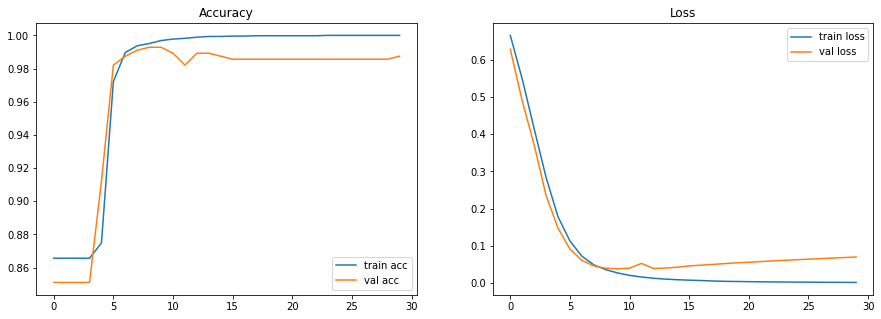

In [24]:
import matplotlib.pyplot as plt
history = history.history
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()


In [25]:
loss ,accuracy = model.evaluate(test)
print("test loss :",loss)
print("test accuracy :",accuracy)

9/9 [==============================] - 1s 128ms/step - loss: 0.0864 - accuracy: 0.9857
test loss : 0.0864335373044014
test accuracy : 0.9856630563735962
